In [2]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test

In [3]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [8]:
n_simulations = 500 
initial_value = 818
sigma = 0.11
n_steps = 50
rf = 0
strike = 820
fc_dims = [16, 16]
LR = 0.01
EPOCHS = 30
p_train = 0.9

bs_params = {"n_simulations": n_simulations,
             "n_steps": n_steps,
             "initial_value": initial_value,
             "sigma": sigma,
             }

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": rf,
                "strike": strike,
                }

payoff_params = {"strike": strike}

n_train = int(p_train * n_simulations)
n_test = n_simulations - n_train

dt = SimulationData(bs_generator, bs_params, bs_call_price, price_params, call_payoff, payoff_params)
dt_train, dt_test = torch.utils.data.random_split(dt, [n_train, n_test])
data_loader_train = DataLoader(dt_train, batch_size=20, shuffle=True)
cn = ControlNet(n_steps, 1, fc_dims, 1)

optimizer = Adam(cn.parameters(), lr=LR)
criterion = torch.nn.MSELoss()
train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer)

Epoch 0: : 23batch [00:00, 27.22batch/s, loss=7.71e+5]
Epoch 1: : 23batch [00:00, 28.26batch/s, loss=7.06e+4]
Epoch 2: : 23batch [00:00, 25.41batch/s, loss=4.36e+4]
Epoch 3: : 23batch [00:00, 34.54batch/s, loss=7.19e+3]
Epoch 4: : 23batch [00:00, 38.12batch/s, loss=6.75e+3]
Epoch 5: : 23batch [00:00, 38.36batch/s, loss=1.4e+3]
Epoch 6: : 23batch [00:00, 35.66batch/s, loss=533]
Epoch 7: : 23batch [00:00, 35.08batch/s, loss=797]
Epoch 8: : 23batch [00:00, 35.27batch/s, loss=238]
Epoch 9: : 23batch [00:00, 36.36batch/s, loss=418]
Epoch 10: : 23batch [00:00, 36.85batch/s, loss=376]
Epoch 11: : 23batch [00:00, 32.96batch/s, loss=393]
Epoch 12: : 23batch [00:00, 29.72batch/s, loss=270]
Epoch 13: : 23batch [00:00, 26.61batch/s, loss=513]
Epoch 14: : 23batch [00:00, 24.64batch/s, loss=440]
Epoch 15: : 23batch [00:00, 31.58batch/s, loss=516]
Epoch 16: : 23batch [00:00, 33.54batch/s, loss=508]
Epoch 17: : 23batch [00:00, 34.38batch/s, loss=162]
Epoch 18: : 23batch [00:00, 35.32batch/s, loss=492]

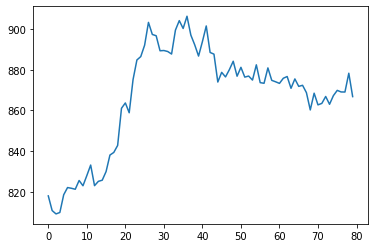

In [5]:
a, b, c, d = next(iter(data_loader_train))
plt.plot(a[0])

In [4]:
def delta(x):
    return bs_delta(n_steps, x, sigma, rf, strike)

In [5]:
# Evaluation In-Sample

_ ,model_loss = test(data_loader_train, cn, criterion)

l = len(data_loader_train.dataset)
x, x_inc, payoff, price = data_loader_train.dataset[:l]

d_hedge = x.apply_(delta)
si = stochastic_integral(x_inc, d_hedge)
delta_loss = criterion(price + si, payoff)

print(model_loss)
print(delta_loss)

tensor(1.5849, grad_fn=<MseLossBackward>)
tensor(2.8651)


In [6]:
# Evaluation Out-Sample
data_loader_test = DataLoader(dt_test, batch_size=20, shuffle=True)

_ ,model_loss = test(data_loader_test, cn, criterion)

l = len(data_loader_test.dataset)
x, x_inc, payoff, price = data_loader_test.dataset[:l]

d_hedge = x.apply_(delta)
si = stochastic_integral(x_inc, d_hedge)
delta_loss = criterion(price + si, payoff)

print(model_loss)
print(delta_loss)

tensor(1.9028, grad_fn=<MseLossBackward>)
tensor(2.7848)
